# Hyperparameter scan

**Goal:** I have this model **Pairagaph** and I want to figure out how to optimize it for the training set that I made that combines the mc campaigns.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from preprocess import *
from trainNet import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
inpt_dim=5
nSelectedJets=5

subDir = f"SMNR_mc16ade_PFlow-AUG2019-{nSelectedJets}jets"

**Baseline**

**What's the deal when the loss sometimes goes *super* negative??**

My hypothesis was that the weights were gettting way too large, but I want to see if I can demonstrate that!

**Why does sometimes the loss tell a very different story from the accuracy??**

See this model I trained yesterday:

`Training a transformer model with 1 encoder layers with 2 heads
embed_dim = 20, ff_dim = 10, dpt = 0.2, lr=0.003.`

In [ ]:
'''
This was a model that I trained that had v large negative weights.
But since I couldn't load in the weights afterwards anyways, I just deleted it,
althought the figures will still be saved in the associated figures folder.
'''

# embed_dim = 20
# ff_dim = 10
# p = 0.2
# nHeads = 2 
# nLayers = 1
# batch_size=2048
# lr = 3e-3

# model = pairAGraph(inpt_dim=inpt_dim,embed_dim=embed_dim,ff_dim=ff_dim,
#                    nHeads=nHeads,p=p)

# specs = f"xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{p}_lr{lr}_batch{batch_size}"
# modelDir = f"models/{subDir}/{specs}/"

# filename = modelDir+"loss_acc.json"
# with open(filename, 'r') as varfile:
#     metrics = json.load(varfile)
# trainingMetrics(metrics)

Recall: Since I have 4x the data in the validation set than the training set, I was multiplying the validation loss by 4 so that it would appear that the two were on the same footing.

Which was the point with the best validation accuracy??

I might need to take a second and remind myself why I thought this was a good loss function... (I can probably write it in my slide show while I'm at it too.)

**What other plots can I make to visualize the data from these random hyperparameter scans?**

- Maybe looking into dependence vs the # of parameters, dropout, # of attention heads, but perhaps I should factor out the learning rate?

**Plan:** I should load the train + val loss + acc into some pandas df so that I can easily analyze the outputs!

In [46]:
cols = ['nLayers','embed_dim', 'ff_dim', 'nHeads', 'dpt', 'lr', 'params']
cols += ['epochs','epoch_bestLoss','epoch_bestAcc']

keys = ["_".join([s,m]) for s in ['train','val'] for m in ['loss','acc','acc_3b','acc_4b']]
cols += ["_".join([k,t]) for k in keys for t in ['bestLoss','bestAcc']]

stats = pd.DataFrame(0,index=range(len(os.listdir(f"models/{subDir}/"))),columns=cols)

In [47]:
for i,specs in enumerate(os.listdir(f"models/{subDir}/")):
    
    modelDir = f"models/{subDir}/{specs}/"
    
    # Step 1: Parse the stringto get the hyperparameters
    flags = specs.split("_")
    
    nLayers = int(flags[1][0])
    embed_dim = int(flags[2][3:])
    ff_dim = int(flags[3][2:])
    nHeads = int(flags[4][0])
    dpt = float(flags[5][3:])
    lr = float(flags[6][2:])
    
    stats.loc[i,'nLayers'] = nLayers
    stats.loc[i,'embed_dim'] = embed_dim
    stats.loc[i,'ff_dim'] = ff_dim
    stats.loc[i,'nHeads'] = nHeads
    stats.loc[i,'dpt'] = dpt
    stats.loc[i,'lr'] = lr

    # Step 2: Load in the metrics
    filename = f"{modelDir}loss_acc.json"
    try:
        with open(filename, 'r') as varfile:
            metrics = json.load(varfile)
        
        # Step 3: Save to a pandas df
        stats.loc[i,'epochs'] = len(metrics['train_loss'])

        for m, tag, f in zip(['loss','acc'], ['bestLoss','bestAcc'], [np.argmin,np.argmax]):

            epoch = f(np.array(metrics[f'val_{m}']))
            stats.loc[i, f'epoch_{tag}'] = epoch

            for k in keys:
                stats.loc[i, f'{k}_{tag}'] = metrics[k][epoch]
    
        # Also save the number of parameters
        model = pairAGraph(inpt_dim=inpt_dim,embed_dim=embed_dim,ff_dim=ff_dim,
                           nHeads=nHeads,p=dpt,nAttnBlocks=nLayers)
        model.to('cuda:6')
        try:
            model.load_state_dict(torch.load(modelDir+f'model.pt'))

            params = sum([np.prod(p.size()) for p in model.parameters()])
            stats.loc[i, 'params'] = params
        except RuntimeError:
            print('devices busy')
    
    except FileNotFoundError:
        print('FileNotFound:',filename)
    

        

In [12]:
np.sum(stats.params == 0)

0

Ok, so it seems like I was a little confused by early stopping when I coded this up...

In [48]:
stats.head()

nLayers  embed_dim  ff_dim  nHeads  dpt      lr  params  epochs  \
0        1         10       5       1  0.1  0.0020    1095      32   
1        1         20      30       4  0.4  0.0050    4810      11   
2        1         10       5       1  0.4  0.0020    1095      26   
3        1         10      10       5  0.2  0.0005    1200      49   
4        1         40      20       5  0.4  0.0020   15180      11   

   epoch_bestLoss  epoch_bestAcc  ...  train_acc_4b_bestLoss  \
0              25             27  ...               0.892113   
1               4              4  ...               0.913640   
2              19             16  ...               0.895908   
3              42             40  ...               0.845732   
4               4              4  ...               0.895984   

   train_acc_4b_bestAcc  val_loss_bestLoss  val_loss_bestAcc  \
0              0.890466           0.061909          0.068015   
1              0.913640           0.071728          0.071728   
2              0.895522           0.059724          0.060723   
3              0.842992           0.079960          0.080669   
4              0.895984           0.063657          0.063657   

   val_acc_bestLoss  val_acc_bestAcc  val_acc_3b_bestLoss  val_acc_3b_bestAcc  \
0          0.848055         0.853720             0.837361            0.835688   
1          0.823603         0.823603             0.810286            0.810286   
2          0.857775         0.861192             0.849031            0.852393   
3          0.798349         0.800023             0.768876            0.771880   
4          0.844273         0.844273             0.833904            0.833904   

   val_acc_4b_bestLoss  val_acc_4b_bestAcc  
0             0.876945            0.895217  
1             0.856047            0.856047  
2             0.883866            0.888620  
3             0.858689            0.858211  
4             0.871297            0.871297  

[5 rows x 26 columns]

**Nice!!** Now how can I analyse this / gain some intuition?

- Let's look at the learning rate as a function of the # of epochs for training
- I want to compare (on the validation set) the difference in performance b/w choosing the best model based on the validation loss or accuracy
- I'd like to try to analyze how the (loss or accuracy) evolves as a function of the # of parameters, and then maybe as a function of the # of attention heads
- I would also like to see how much *stochasticity* is in the training, as in retraining a model with the *same* hyperparameter 5-10x and see how much variation there are in the metrics of interest for my selected model.

In [14]:
np.min(stats.lr),np.max(stats.lr)

(0.0005, 0.01)

In [15]:
np.min(stats.lr),np.max(stats.lr)

(0.0005, 0.01)

In [32]:
subDir

'SMNR_mc16ade_PFlow-AUG2019-5jets'

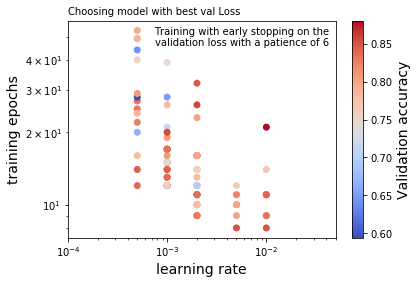

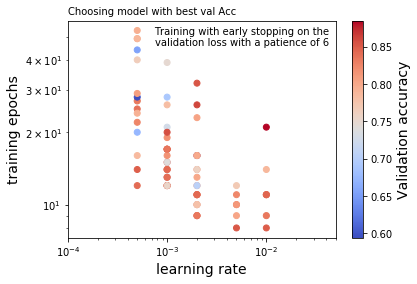

In [45]:
for t in ['bestLoss','bestAcc']:

    plt.scatter(stats.loc[stats.lr != 0,'lr'], stats.loc[stats.lr != 0,'epochs'], 
                c=stats.loc[stats.lr != 0,f'val_acc_{t}'], cmap='coolwarm')

    plt.xlabel('learning rate',fontsize=14)
    plt.ylabel('training epochs',fontsize=14)

    cbar = plt.colorbar()
    cbar.set_label('Validation accuracy',fontsize=14)

    plt.xlim(1e-4,.05)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.text(.975,.975,'Training with early stopping on the\nvalidation loss with a patience of 6',
             ha='right',va='top',transform=ax.transAxes)
    
    plt.title(f'Choosing model with best val {t[4:]}',loc='left',fontsize=10)
    plt.savefig(f'figures/{subDir}/epochs_vs_lr_{t}.pdf',bbox_inches='tight')
    plt.show()

**Lessons from the max correct non-adjacent edges loss function**
- Ok, I am slightly seeing this negative trend, but not as dramatic as before.


**Lessons (from the jet compatibility loss function):** 
- I'm seeing the trend that I was expecting to see, that when I use a smaller learning rate, I need to train for longer before converging.
- Something that I thought was interesting was that the smaller learning rates are not necessarily translating into better converged models.
- Note: Most of the points in this plot were actually trained with an early stopping patience of 6, some with *more*, so I might need to clean this up a bit before saving and showing.

In [17]:
subDir

'SMNR_mc16ade_PFlow-AUG2019-5jets'

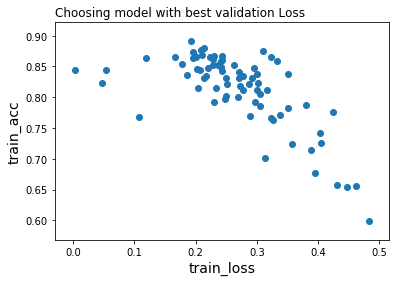

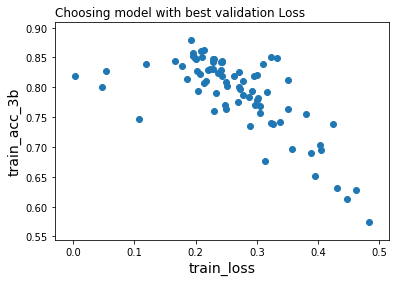

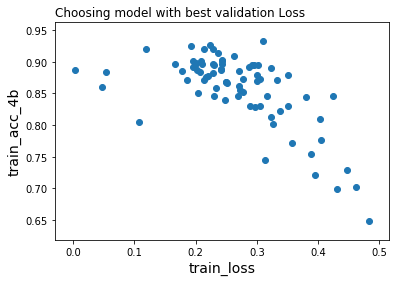

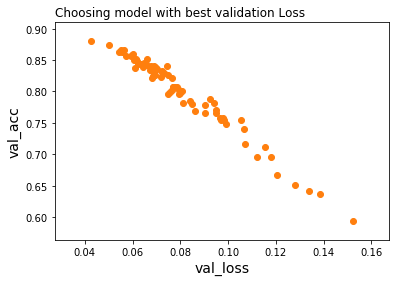

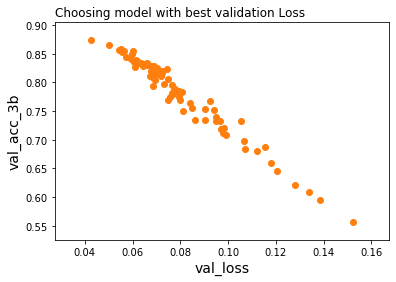

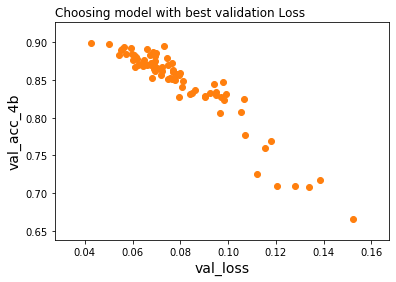

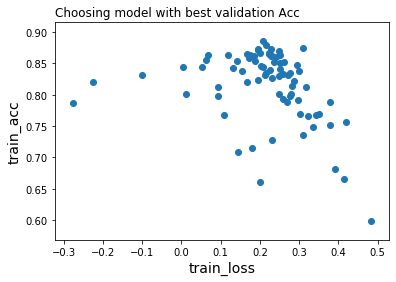

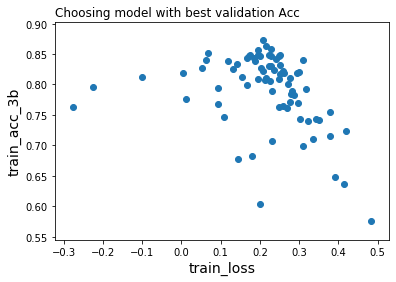

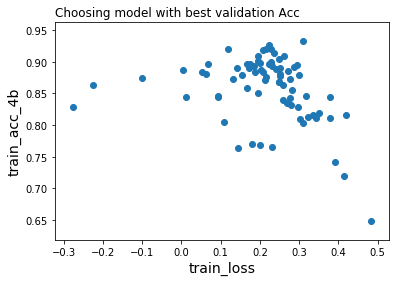

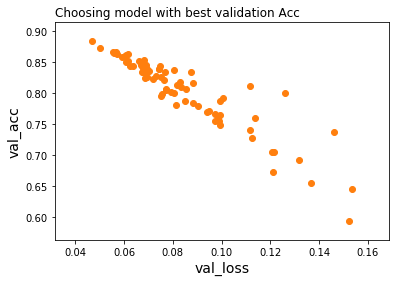

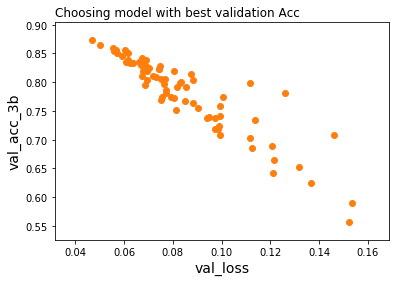

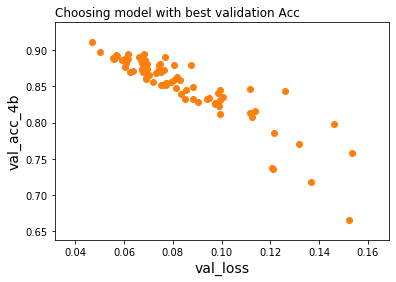

In [39]:
# Next let's compare the trend between loss and accuracy, for the training and test sets

for t in ['bestLoss','bestAcc']:

    for s, c in zip(['train','val'],['C0','C1']):
        
        for a in ['acc','acc_3b','acc_4b']:
        
            plt.figure()
            x, y = f'{s}_loss_{t}', f'{s}_{a}_{t}'
            plt.scatter(stats[x],stats[y],color=c)#cmap=cmap)

            plt.xlabel(f'{s}_loss',fontsize=14)
            plt.ylabel(f'{s}_{a}',fontsize=14)

            plt.title(f'Choosing model with best validation {t[4:]}',loc='left')
            plt.savefig(f'figures/{subDir}/{s}_loss_vs_{a}_{t}.pdf')
            plt.show()
    

Ok, so the good news from looking at these metrics is that it seems like we have a pretty clear winner in terms of the best model. The 4b validation accuracy is slightly *less* than 90%, which is honestly a bit worse than I might have expected, but maybe I just need to do a better exploration of the hyperparameter space?

**Plan:** I'm going to try to do some diagnostics to see which hyperparameters are the most promising.

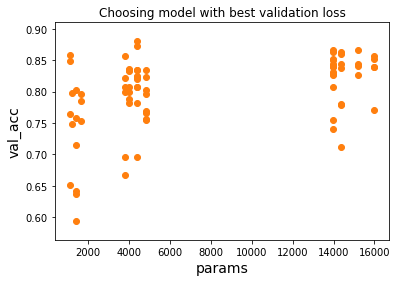

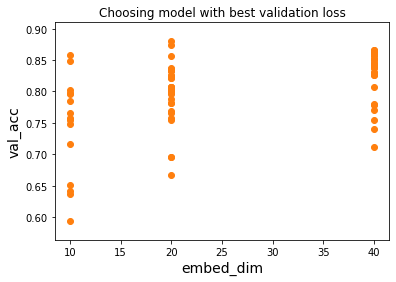

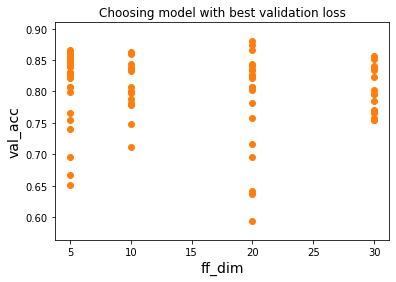

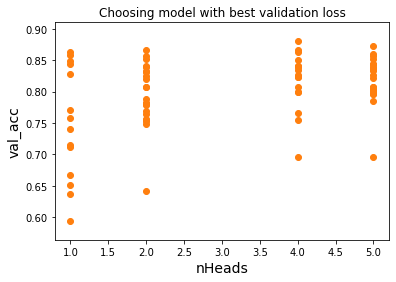

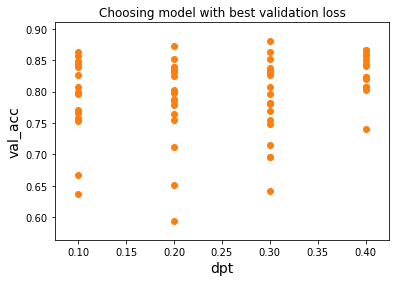

In [19]:
for c in ['params','embed_dim', 'ff_dim', 'nHeads', 'dpt']:
    plt.figure()
    #x, y = f'{s}_loss_{t}', f'{s}_{a}_{t}'
    plt.scatter(stats[c],stats['val_acc_bestLoss'],color='C1')#cmap=cmap)

    plt.xlabel(c,fontsize=14)
    plt.ylabel(f'val_acc',fontsize=14)

    plt.title(f'Choosing model with best validation loss')

Ok, so this is *not at all* helpful... Let's try looking at some 2d plots instead!!

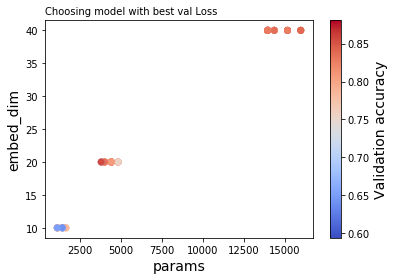

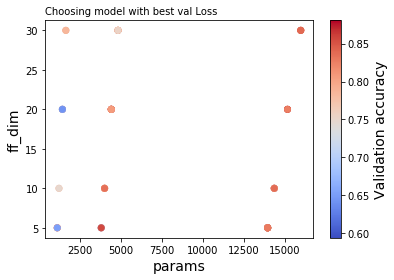

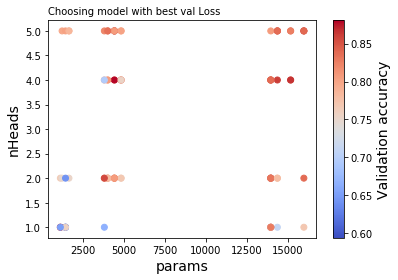

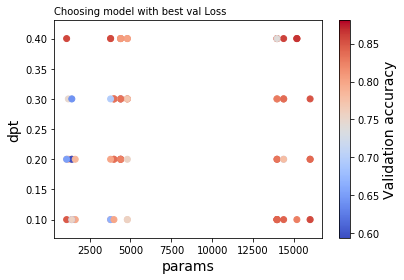

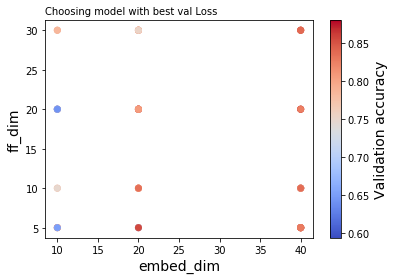

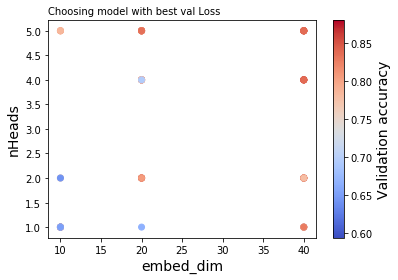

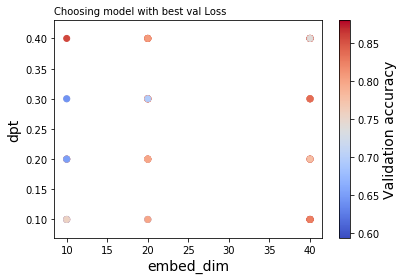

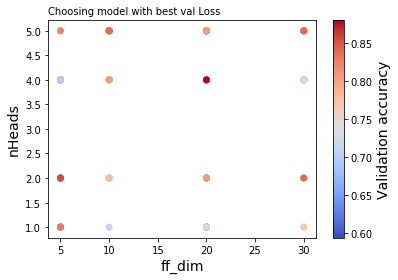

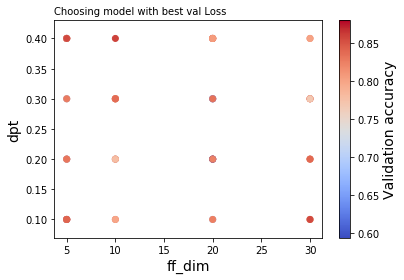

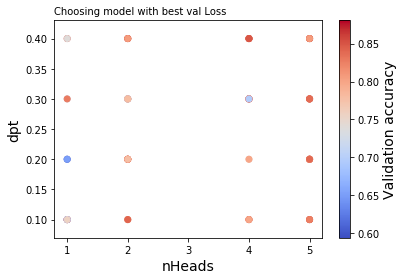

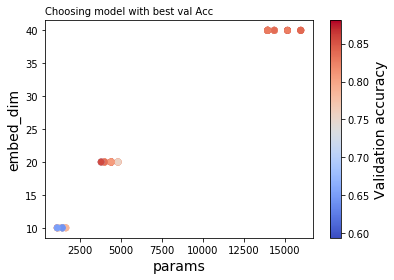

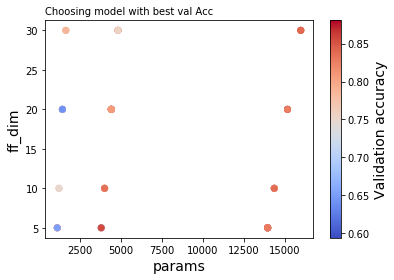

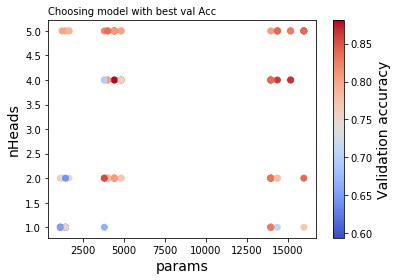

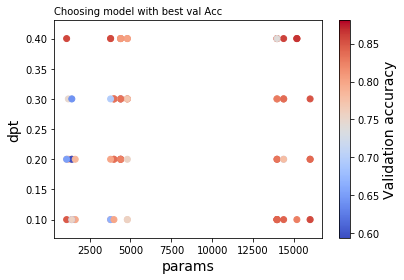

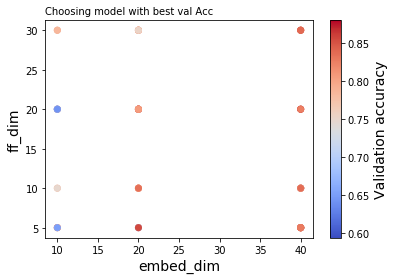

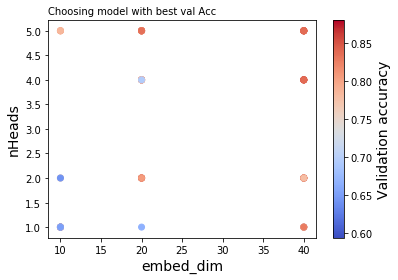

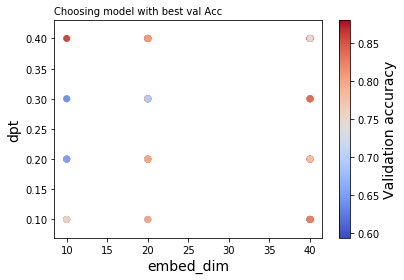

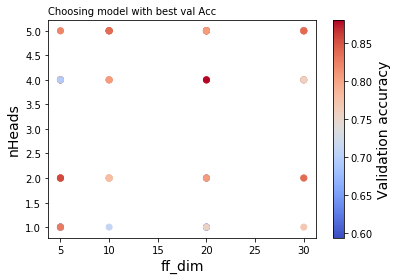

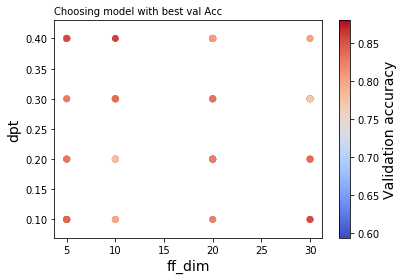

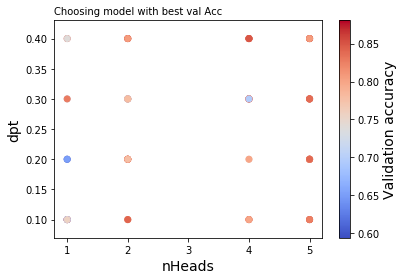

In [44]:
myCols = ['params','embed_dim', 'ff_dim', 'nHeads', 'dpt']

for t in ['bestLoss','bestAcc']:
    for i in range(len(myCols)):
        for j in range(i+1,len(myCols)):

            c1, c2 = myCols[i], myCols[j]

            plt.scatter(stats[c1], stats[c2], c=stats.val_acc_bestLoss, cmap='coolwarm')

            plt.xlabel(c1,fontsize=14)
            plt.ylabel(c2,fontsize=14)

            cbar = plt.colorbar()
            cbar.set_label('Validation accuracy',fontsize=14)

            plt.title(f'Choosing model with best val {t[4:]}',loc='left',fontsize=10)
            plt.savefig(f'figures/{subDir}/{c2}_vs_{c1}_{t}.pdf',bbox_inches='tight')
            plt.show()

In [21]:
np.max(stats.val_acc_bestAcc),np.max(stats.val_acc_bestLoss)

(0.8848351240158081, 0.8807275891304016)

In [22]:
np.max(stats.val_acc_4b_bestAcc),np.max(stats.val_acc_4b_bestLoss)

(0.9113161563873291, 0.8992481231689453)

**Plan:** I'm going to choose the model with the best validation accuracy.

In [49]:
iloc = stats.val_acc_bestAcc.idxmax()

In [29]:
iloc

24

In [50]:
stats.iloc[iloc]

nLayers                     1.000000
embed_dim                  20.000000
ff_dim                     20.000000
nHeads                      4.000000
dpt                         0.300000
lr                          0.010000
params                   4400.000000
epochs                     21.000000
epoch_bestLoss             14.000000
epoch_bestAcc              19.000000
train_loss_bestLoss         0.192619
train_loss_bestAcc          0.208780
train_acc_bestLoss          0.892110
train_acc_bestAcc           0.886177
train_acc_3b_bestLoss       0.878754
train_acc_3b_bestAcc        0.872229
train_acc_4b_bestLoss       0.924147
train_acc_4b_bestAcc        0.918469
val_loss_bestLoss           0.042659
val_loss_bestAcc            0.046666
val_acc_bestLoss            0.880728
val_acc_bestAcc             0.884835
val_acc_3b_bestLoss         0.873958
val_acc_3b_bestAcc          0.873446
val_acc_4b_bestLoss         0.899248
val_acc_4b_bestAcc          0.911316
Name: 24, dtype: float64

- All of these plots of the variables as a function of the individual variables aren't really helpful.
- I might want to add an $\epsilon$ to these points because it's hard to see trends when they're all on top of each other.

What if you average the predictions from the 5 best models in terms of the validation loss?

**Question:** With this new loss, do the loss and accuracy now tell exacly the same stories?

### Analyzing the loss function

Ok, so I've been playing around with a couple of different ideas for encode this jet compatibility, but I think that some other metrics that *might* be nice to compare would be the entropy, and the probability of the correct pair versus the other pairs, because training with the jet compatibility loss seems *more stable*, but I'm not 100% sure why atm.